In [1]:
# import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate,optimize
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities, SpiralArmsPotential
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
import gd1_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


# Setup the spiral arms

Cox and Gomez : $\phi$ + $\Omega$ t - $\phi_{p}(r_{o})$

Monari et al : $\phi$ - $\Omega_{s}$ t - $\phi_{s}$, they took $\Omega_{s}$ $t_{e}$ - $\phi_{s} = -26^{\circ}$  

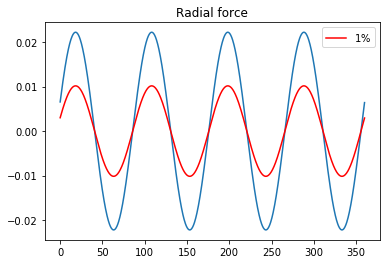

In [3]:
#Monari's phi_s is phi_ref in galpy
#Monari also doesn't have exponential decay along the radius. Cox and Gomez and galpy
#have a radial exponential decay with scale length Rs=7 kpc (Cox and Gomez)

def initial_angle(pat_speed,t_age_Gyr=5.,fin_phi_deg=26.):
    
    kpc_to_km= 1000*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
    Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
    o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

    fin_phi= np.radians(fin_phi_deg)
    init_phi= fin_phi - o_p*(t_age_Gyr*Gyr_to_s)
    return init_phi



#compute max radial force for the spiral with amp=1
#compute and save result to save computing time.
N=4
pat_speed = 18.9
pitch_angle=9.9
t_age=9.
r_ref=8. #kpc
Rs=7. #kpc
phi0=26.
H=0.3 #kpc

FR_frac=0.01   #1%

omega=pat_speed*(ro/vo)
alpha=numpy.radians(pitch_angle)
r_ref/=ro
Rs/=ro
H/=ro
phi_ref=initial_angle(pat_speed=pat_speed,t_age_Gyr=t_age,fin_phi_deg=phi0)

Cs=[1]
#Cs=[8./(3.*numpy.pi),0.5,8./(15.*numpy.pi)]


pp=np.linspace(0.,359.9,1000)
FR_nonaxi=[]

spiral_pot_amp1=SpiralArmsPotential(amp=1.,N=N,omega=omega,alpha=alpha,phi_ref=phi_ref,r_ref=r_ref,H=H,Rs=Rs,Cs=Cs)
turn_physical_off(spiral_pot_amp1)


for ii in range(len(pp)):
     FR_nonaxi.append(potential.evaluateRforces(spiral_pot_amp1,R=8./ro,z=0.,phi=numpy.radians(pp[ii]),t=0.))

interp_FR_nonaxi= interpolate.InterpolatedUnivariateSpline(pp,FR_nonaxi)




max_phi=optimize.fmin(interp_FR_nonaxi, 0.,disp=0)

max_FR_nonaxi= interp_FR_nonaxi(max_phi)

FR_axi=potential.evaluateRforces(MWPotential2014,R=8./ro,z=0.,t=0.)

amp=FR_frac*FR_axi/max_FR_nonaxi

#setup spiral potential with correct amplitude
spiralpot=SpiralArmsPotential(amp=amp,N=N,omega=omega,alpha=alpha,phi_ref=phi_ref,r_ref=r_ref,H=H,Rs=Rs,Cs=Cs)
turn_physical_off(spiralpot)


FR=[]

for ii in range(len(pp)):
    FR.append(potential.evaluateRforces(spiralpot,R=8./ro,z=0.,phi=numpy.radians(pp[ii]),t=0.))


plt.figure()
plt.plot(pp,interp_FR_nonaxi(pp))
plt.plot(pp,FR,c='r',label=r'$1\%$')
plt.title('Radial force')
plt.legend(loc='upper right')
plt.show()
    


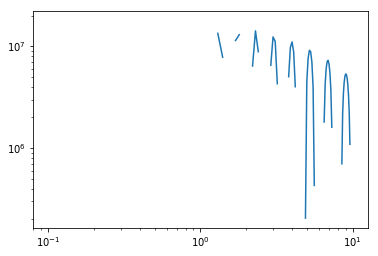

In [4]:
rr=np.linspace(0.1,10.,100)
dens_eval=[]

dens_eval=[evaluateDensities(spiralpot,r*u.kpc,0.*u.kpc,np.radians(0.))*(10**9)*bovy_conversion.dens_in_msolpc3(220.,8.) for r in rr]


loglog(rr*u.kpc,dens_eval)

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SpiralArmsPotential.py:146: RuntimeWarning: overflow encountered in power
  * np.sum(self._Cs / Ks / Ds * np.cos(self._ns * self._gamma(R, phi - self._omega * t)) / np.cosh(Ks * z / Bs) ** Bs)



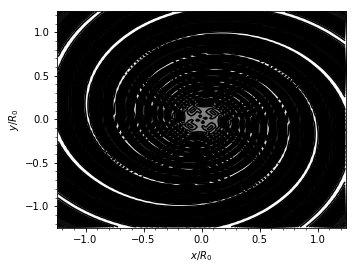

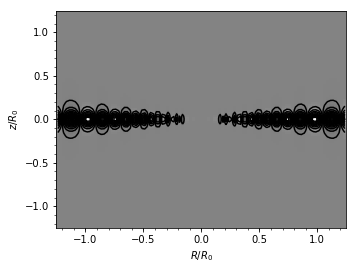

In [5]:
#plot the spiral's potential contours
potential.plotPotentials(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)


potential.plotPotentials(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,phi=0.)



/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SpiralArmsPotential.py:554: RuntimeWarning: divide by zero encountered in log
  return self._N * (phi - self._phi_ref - np.log(R / self._r_ref) / self._tan_alpha)

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SpiralArmsPotential.py:562: RuntimeWarning: divide by zero encountered in true_divide
  return self._ns * self._N / R / self._sin_alpha

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SpiralArmsPotential.py:570: RuntimeWarning: divide by zero encountered in true_divide
  HNn_R = self._HNn / R

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SpiralArmsPotential.py:581: RuntimeWarning: divide by zero encounter

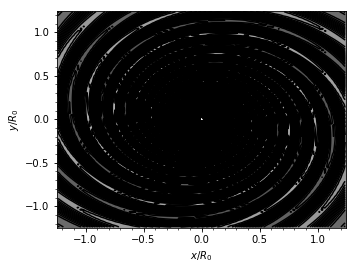

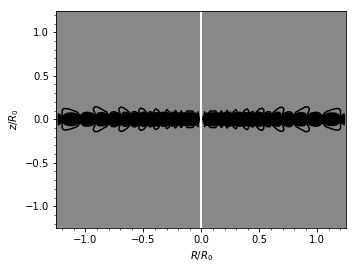

In [6]:
#plot the spiral's density contours

plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)

plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80)


In [7]:
#add to MW potential

#MWspiralpot=[MWPotential2014[0],MWPotential2014[1],MWPotential2014[2]]+spiralpot

MWspiralpot = MWPotential2014 + [spiralpot]

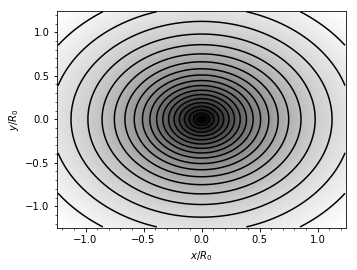

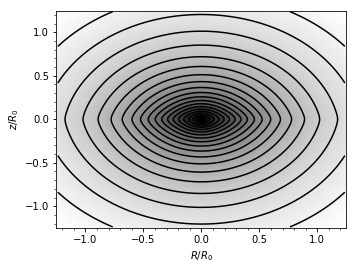

In [8]:
#plot potential

potential.plotPotentials(MWspiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)
potential.plotPotentials(MWspiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,phi=0.)

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/PowerSphericalPotentialwCutoff.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./r**self.alpha*nu.exp(-(r/self.rc)**2.)

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.



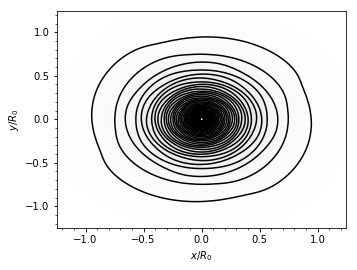

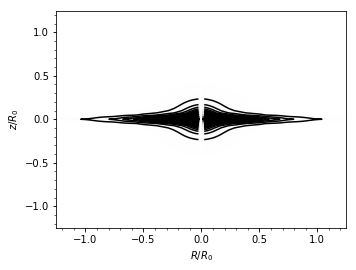

In [9]:
#plot density

plotDensities(MWspiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)

plotDensities(MWspiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80)


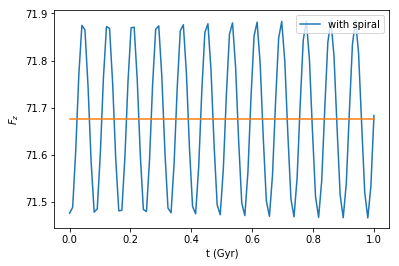

In [10]:
#evaluate vertical force at the Sun

from galpy.potential import evaluatezforces

Fz_spiral=[]
Fz=[]
t=linspace(0.,1.,100)*u.Gyr

for ii in t:
    Fz_spiral.append(-evaluatezforces(MWspiralpot, 1.,1.1/8.,phi=0.,t=ii)*bovy_conversion.force_in_2piGmsolpc2(220.,8.))
    Fz.append(-evaluatezforces(MWPotential2014, 1.,1.1/8.,phi=0.,t=ii)*bovy_conversion.force_in_2piGmsolpc2(220.,8.))
    
plt.figure()
plt.plot(t,Fz_spiral,label='with spiral')
plt.plot(t,Fz)
plt.ylabel(r'$F_{z}$')
plt.xlabel('t (Gyr)')
plt.legend(loc='upper right')
plt.show()
    

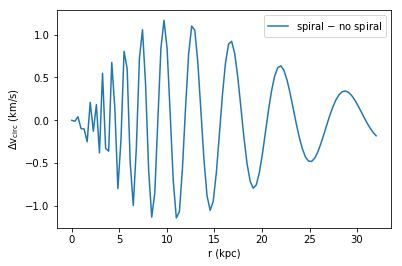

In [11]:
#circular velocity

rr=np.linspace(0.001,4.,100)

MWsp=[]
diff=[]
for r in rr :
    diff.append(potential.vcirc(MWspiralpot,r,phi=0)*vo - potential.vcirc(MWPotential2014,r,phi=0)*vo )

plt.figure()
#plt.plot(rr*8.,potential.vcirc(MWPotential2014,rr,phi=0)*vo)
plt.plot(rr*8.,diff,label='spiral $-$ no spiral')
plt.legend(loc='upper right')
#plt.ylim(0,250)
#plt.xlim(0,30)
plt.xlabel(r'r (kpc)')
plt.ylabel(r'$\Delta$v$_{\rm{circ}}$ (km/s)')
plt.show()

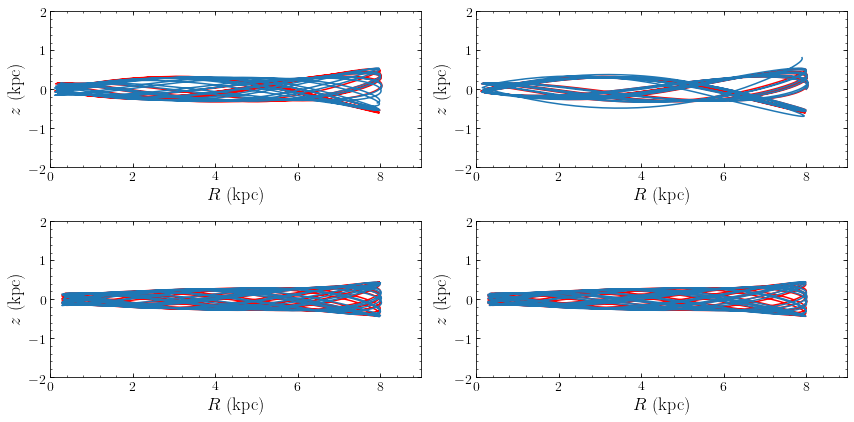

In [12]:
#plot orbits


ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,MWPotential2014)
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True,c='r')
    o.integrate(ts,MWspiralpot)
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,MWPotential2014)
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True,c='r')
    o.integrate(ts,MWspiralpot)
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()




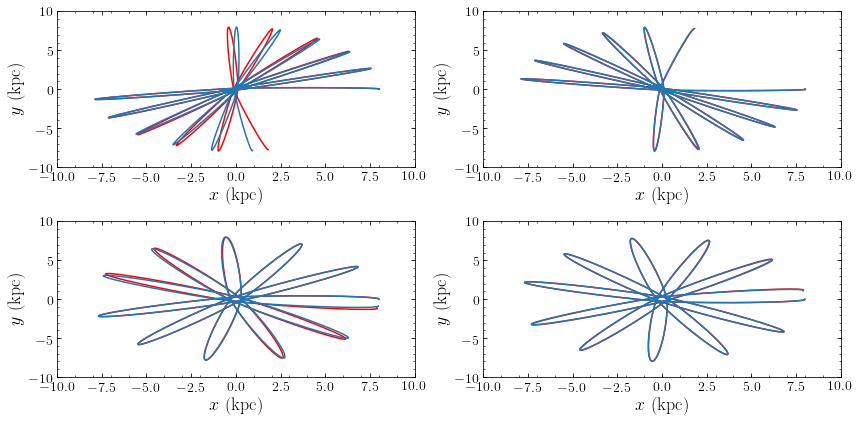

In [13]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
tight_layout()


# Effect of Mbar on Pal 5

In [14]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

[ 0.  1.  2.  3.  4.  5.]
/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



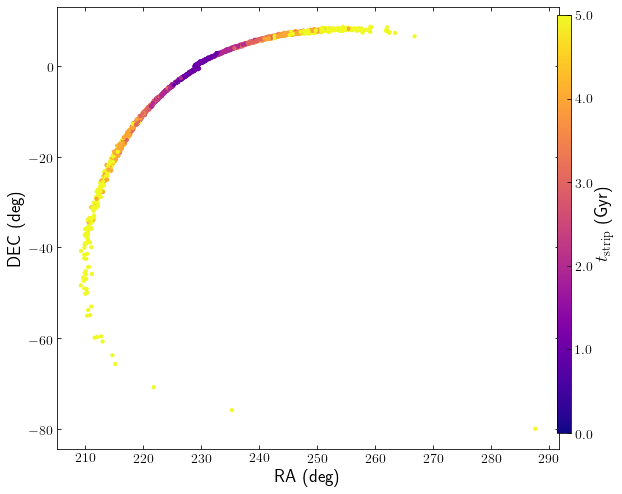

In [15]:
#setup Pal 5 smooth stream, only the trailing arm at the moment, for different potentials


sdf_trailing= pal5_util.setup_pal5model(pot=MWPotential2014)
sdf_leading= pal5_util.setup_pal5model(pot=MWPotential2014,leading=True)

#Sample N points from the smooth model today 
N=1000
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)

trackRADec_leading=bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)

#add color label based on time of stripping

#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

lt_unp=numpy.empty(N)
bt_unp=numpy.empty(N)
dtt_s=numpy.empty(N)

ll_unp=numpy.empty(N)
bl_unp=numpy.empty(N)
dtl_s=numpy.empty(N)

for i in range(N):
    dtt_s[i]=numpy.digitize(dtt[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    lt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[0]
    bt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[1]
    
    dtl_s[i]=numpy.digitize(dtl[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    ll_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[0]
    bl_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[1]
    
radec1t=bovy_coords.lb_to_radec(lt_unp,bt_unp,degree=True) 
radec1l=bovy_coords.lb_to_radec(ll_unp,bl_unp,degree=True)

#plot unperturbed stream 

plt.figure(figsize=(8,7))
plt.scatter(radec1t[:,0],radec1t[:,1],s=10,color=color_from_colormap(dtt_s,cmap,0.,5.))
plt.scatter(radec1l[:,0],radec1l[:,1],s=10,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k')
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.xlim(220.,290.)
#plt.ylim(-10.,10.)
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/smooth_Pal5_10_10Msun_patspeed35_ang27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()


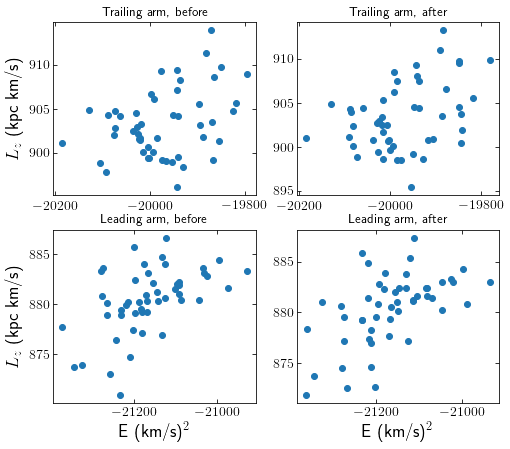

In [16]:
#plot E vs Lz

nsamp=50

Et0=[]
Et1=[]

Lzt0=[]
Lzt1=[]

El0=[]
El1=[]

Lzl0=[]
Lzl1=[]


for ii in range(nsamp):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]],ro=ro,vo=vo).flip()
    ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]],ro=ro,vo=vo).flip()# flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    tsl= numpy.linspace(0.,dtl[ii],1001)
    
    ot.integrate(tst,MWPotential2014) #integrate back to stripping point
    ott=ot(tst[-1]).flip()  #flip velocities for forward integration
    ott.integrate(tst,MWspiralpot) 
    Et0.append(ott.E(tst[0]))   #Energy at the stripping time 
    Et1.append(ott.E(tst[-1]))   # Energy at present
    Lzt0.append(ott.L(tst[0])[0,2]) #Lz at stripping time
    Lzt1.append(ott.L(tst[-1])[0,2])   #Lz at present
    
    ol.integrate(tsl,MWPotential2014)
    oll=ol(tsl[-1]).flip()
    oll.integrate(tsl,MWspiralpot)
    El0.append(oll.E(tsl[0]))
    El1.append(oll.E(tsl[-1]))
    Lzl0.append(oll.L(tsl[0])[0,2])
    Lzl1.append(oll.L(tsl[-1])[0,2])
    

plt.figure(figsize=(8,7))
plt.subplot(2,2,1)
plt.title('Trailing arm, before')
plt.scatter(Et0,Lzt0)
plt.ylabel(r'$L_{z}$ (kpc km/s)')

plt.subplot(2,2,2)
plt.title('Trailing arm, after')
plt.scatter(Et1,Lzt1)

plt.subplot(2,2,3)
plt.title('Leading arm, before')
plt.scatter(El0,Lzl0)
plt.xlabel(r'E (km/s)$^2$')
plt.ylabel(r'$L_{z}$ (kpc km/s)')

plt.subplot(2,2,4)
plt.title('Leading arm, after')
plt.scatter(El1,Lzl1)
plt.xlabel(r'E (km/s)$^2$')

#plt.savefig('plots/E_Lz_Mbar10_10_speed35_ang27.pdf',format='pdf',dpi=1000)
plt.show()

     

975


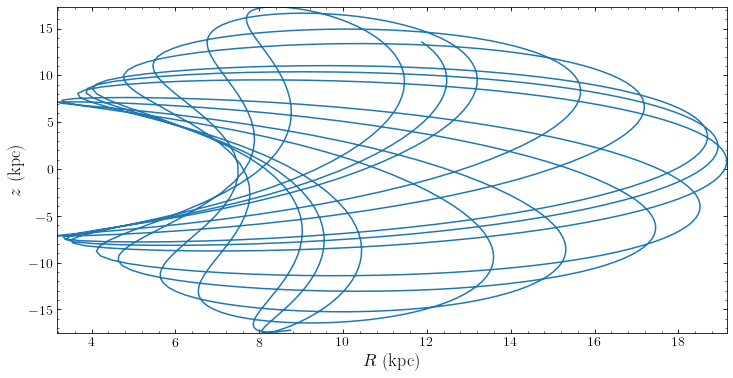

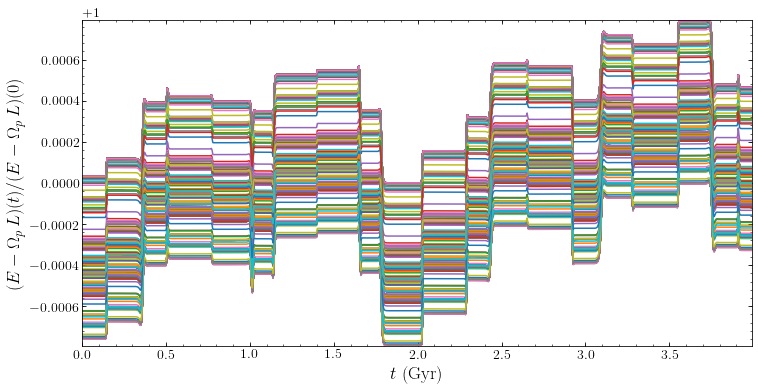

In [18]:
#Jacobi integral

#randomly pick a star, integrate back in axi pot, integrate forward in barred pot

from random import randint
ind=randint(0,len(Rt)-1)
print (ind)


#trailing arm

ot= Orbit([Rt[ind],vRt[ind],vTt[ind],zt[ind],vzt[ind],phit[ind]],ro=ro,vo=vo).flip()# flip flips the velocities for backwards integration

tst= numpy.linspace(0.,dtt[ind],1000)

    
ot.integrate(tst,MWPotential2014) #integrate back to stripping point

ott=ot(tst[-1]).flip()  #flip velocities for forward integration
ott.integrate(tst,MWspiralpot) 

ott.plot()

ott.plotJacobi(normed=True)

#Orbit.plotJacobi(ott,normed=True)



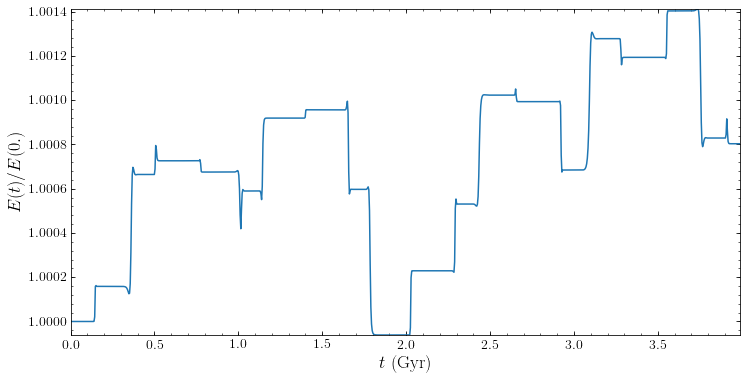

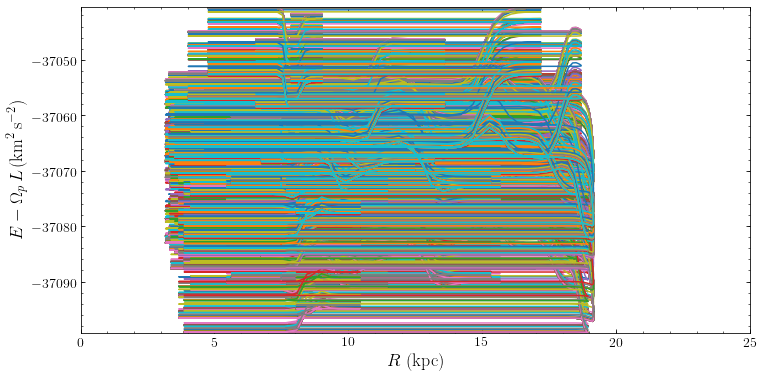

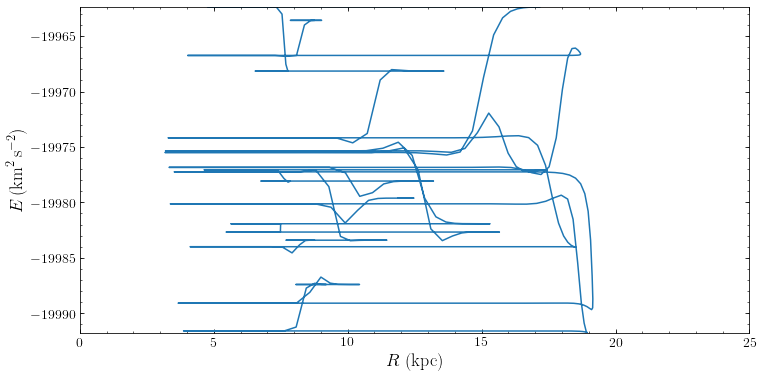

In [19]:
ott.plotE(normed=True)
#plt.savefig('plots/E_vs_t_Mbar10_10_speed35_ang27.pdf',format='pdf',dpi=1000)

#plot Jacobi integral w.r.t the radius 

ott.plot(d1='R',d2='Jacobi',xrange=[0.,25])
#plt.savefig('plots/Jacobi_vs_R_Mbar10_10_speed35_ang27.pdf',format='pdf',dpi=1000)

ott.plot(d1='R',d2='E',xrange=[0.,25])

#plt.savefig('plots/E_vs_R_Mbar10_10_speed35_ang27.pdf',format='pdf',dpi=1000)

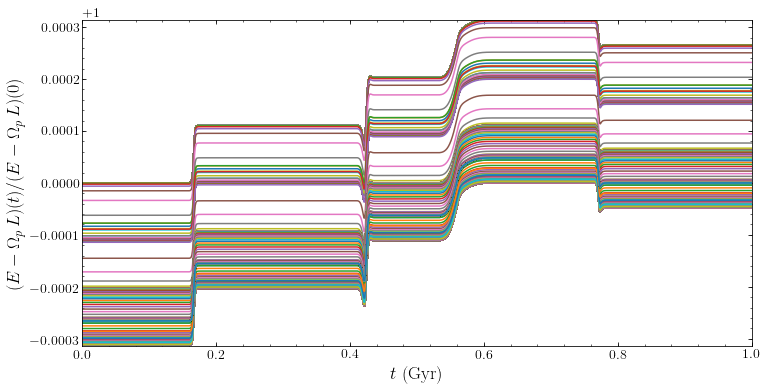

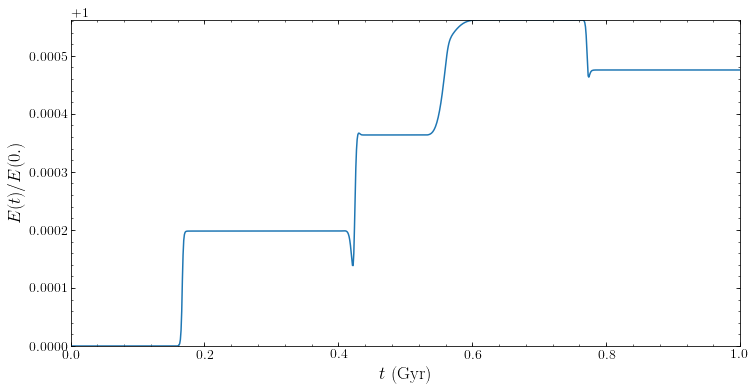

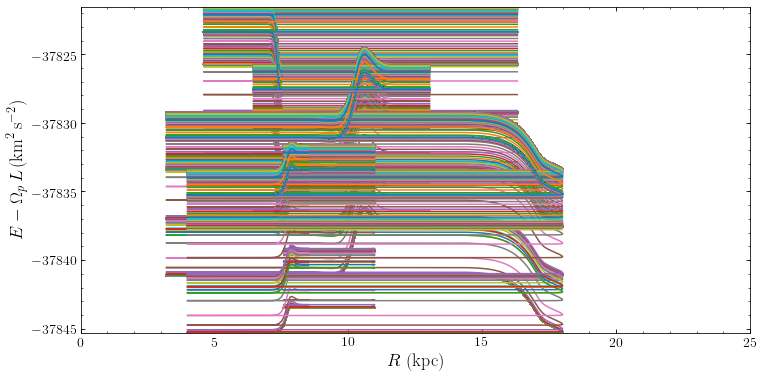

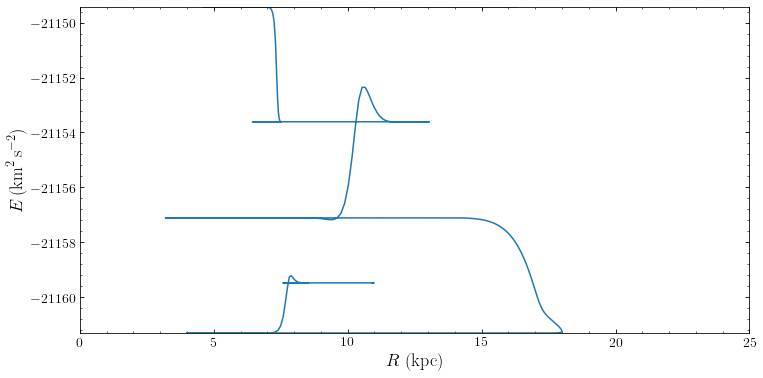

In [20]:
#leading arm

ol= Orbit([Rl[ind],vRl[ind],vTl[ind],zl[ind],vzl[ind],phil[ii]],ro=ro,vo=vo).flip()
tsl= numpy.linspace(0.,dtl[ind],1001)

ol.integrate(tsl,MWPotential2014) #integrate back to stripping point
oll=ol(tsl[-1]).flip()  #flip velocities for forward integration
oll.integrate(ts,MWspiralpot) 
oll.plotJacobi(normed=True)
oll.plotE(normed=True)


oll.plot(d1='R',d2='Jacobi',xrange=[0.,25])
oll.plot(d1='R',d2='E',xrange=[0.,25])
#axvline(dp._rb*ro,c='r') # this plots the bar radius

In [21]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like
orbitst= []
orbitsl= []

N=1000

finalRt= numpy.empty(N)
finalphit= numpy.empty(N)
finalzt= numpy.empty(N)

finalRl= numpy.empty(N)
finalphil= numpy.empty(N)
finalzl= numpy.empty(N)

lt_p=numpy.empty(N)
bt_p=numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)


for ii in range(N):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]]).flip() # flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    ot.integrate(tst,MWPotential2014)
    orbitst.append(ot(tst[-1]).flip()) # get the orbit at the final time step, flip the velocities for forward integration below
    
    #leading   
    ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]]).flip() # flip flips the velocities for backwards integration
    tsl= numpy.linspace(0.,dtl[ii],1001)
    ol.integrate(tsl,MWPotential2014)
    orbitsl.append(ol(tsl[-1]).flip())  # get the orbit at the final time step, flip the velocities for forward integration below
        
    
    #forward integrate in barred potential
    orbitst[ii].integrate(tst,MWspiralpot)
    finalRt[ii]= orbitst[ii].R(tst[-1])
    finalphit[ii]= orbitst[ii].phi(tst[-1])
    finalzt[ii]= orbitst[ii].z(tst[-1])
       
    #leading
    orbitsl[ii].integrate(tsl,MWspiralpot)
    finalRl[ii]= orbitsl[ii].R(tsl[-1])
    finalphil[ii]= orbitsl[ii].phi(tsl[-1])
    finalzl[ii]= orbitsl[ii].z(tsl[-1])
    
    
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "



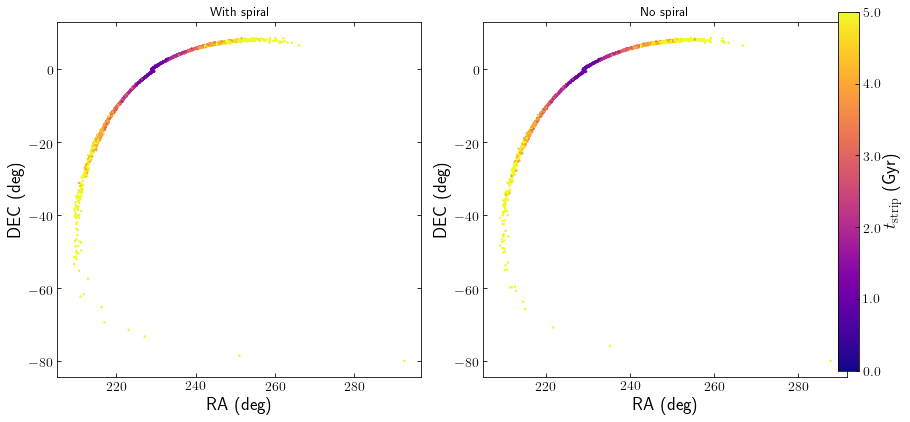

In [22]:
from decimal import Decimal

plt.figure(figsize=(12,6))
plt.subplot(1,2, 1)

plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')
plt.title('With spiral')
plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')



plt.subplot(1, 2, 2)
plt.title('No spiral')
plt.scatter(radec1t[:,0],radec1t[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

plt.scatter(radec1l[:,0],radec1l[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend(loc='upper left')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/Pal5_Mbar10_10Msun_patspeed35_barangle27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()


    